In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
from google.colab import drive
drive.mount("/content/drive")
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


Mounted at /content/drive


In [ ]:
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

!mkdir kaggle_data

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('skin-cancer9-classesisic.zip', 'r')
zip_ref.extractall('/content/kaggle_data/isic-classic')
zip_ref.close()


## Checking GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Defining Directories

In [ ]:
data_dir_train = pathlib.Path("/content/kaggle_data/isic-classic/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/kaggle_data/isic-classic/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training Images : ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Testing Images : ", image_count_test)

Training Images :  2239
Testing Images :  118


### Creating Batches Of Images for Preprocessing

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Creating Training Dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Creating Validation Dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Creating Test Dataset

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


## Classes Of Images

In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


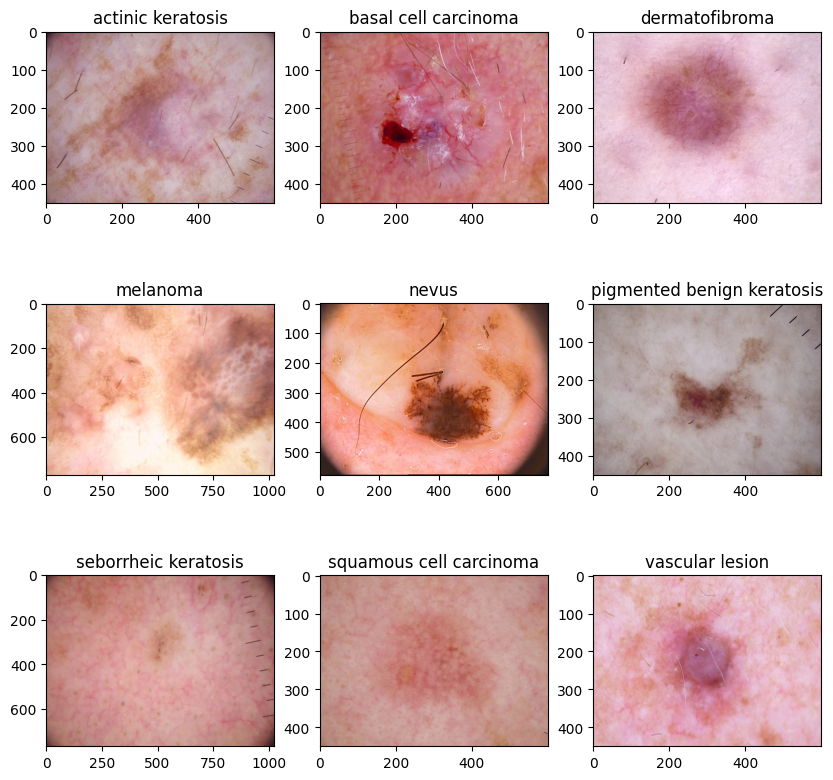

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


### Optimizing Training And Validation Dataset

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating CNN Model

In [ ]:
num_classes = 9
model = Sequential([layers.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

### Training The Model

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - accuracy: 0.1942 - loss: 2.0978 - val_accuracy: 0.3087 - val_loss: 1.8880
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2940 - loss: 1.8824 - val_accuracy: 0.3870 - val_loss: 1.6933
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3959 - loss: 1.6668 - val_accuracy: 0.4139 - val_loss: 1.6091
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4177 - loss: 1.6208 - val_accuracy: 0.4765 - val_loss: 1.5389
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4484 - loss: 1.5123 - val_accuracy: 0.4228 - val_loss: 1.6086
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4577 - loss: 1.5417 - val_accuracy: 0.4765 - val_loss: 1.4738
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5309 - loss: 1.3666 - val_accuracy: 0.4855 - val_loss: 1.5139
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5199 - loss: 1.3401 - val_accuracy: 0.5101 -

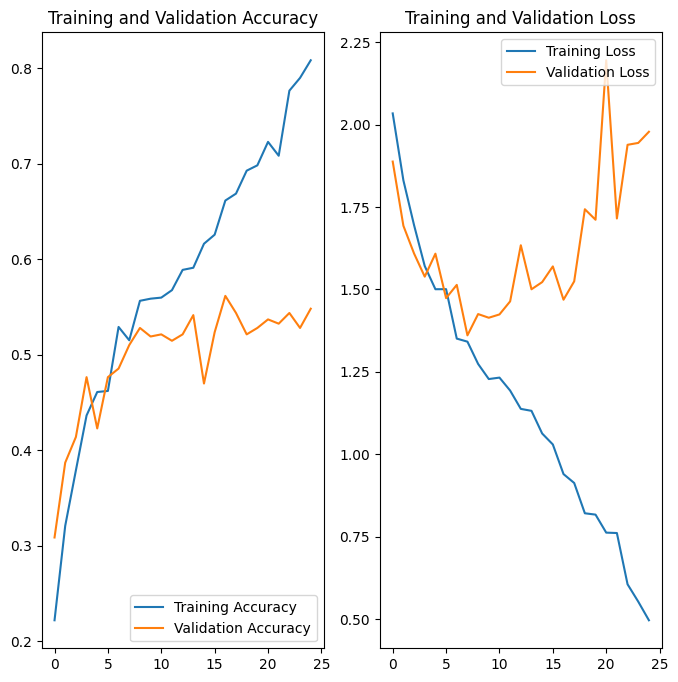

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings


* The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%
* The training accuracy is just around 70-75% with 25 epochs and the model is yet to learn the many features.

* Data Imbalance might be causing the bias to the model.

#### Trying to Reduce Overfitting, Using Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)


#### Augmented Images

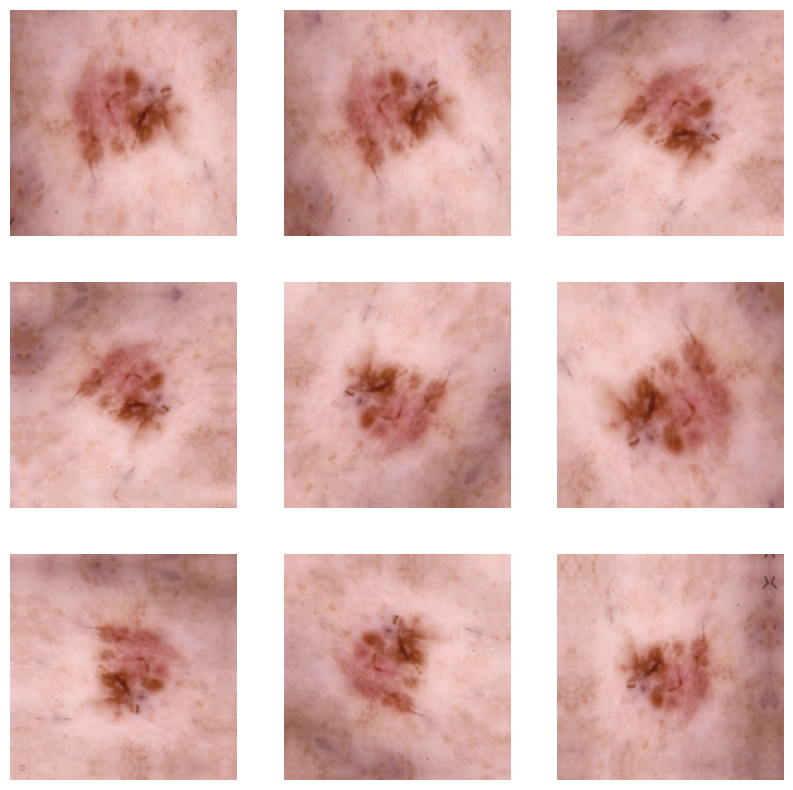

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating New Model With Data Augmentation And Dropout Layer

In [ ]:
num_classes = 9
model = Sequential()
model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(0.2))
model.add(layers.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.1873 - loss: 2.1479 - val_accuracy: 0.1924 - val_loss: 2.0288
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.1838 - loss: 2.0157 - val_accuracy: 0.1499 - val_loss: 2.0421
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.2011 - loss: 2.0057 - val_accuracy: 0.3468 - val_loss: 1.7772
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3709 - loss: 1.6963 - val_accuracy: 0.3937 - val_loss: 1.6612
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4122 - loss: 1.6364 - val_accuracy: 0.4318 - val_loss: 1.5476
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4320 - loss: 1.5552 - val_accuracy: 0.4586 - val_loss: 1.5520
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4471 - loss: 1.5318 - val_accuracy: 0.4832 - val_loss: 1.5117
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4698 - loss: 1.4650 - val_accuracy: 0.4944 - v

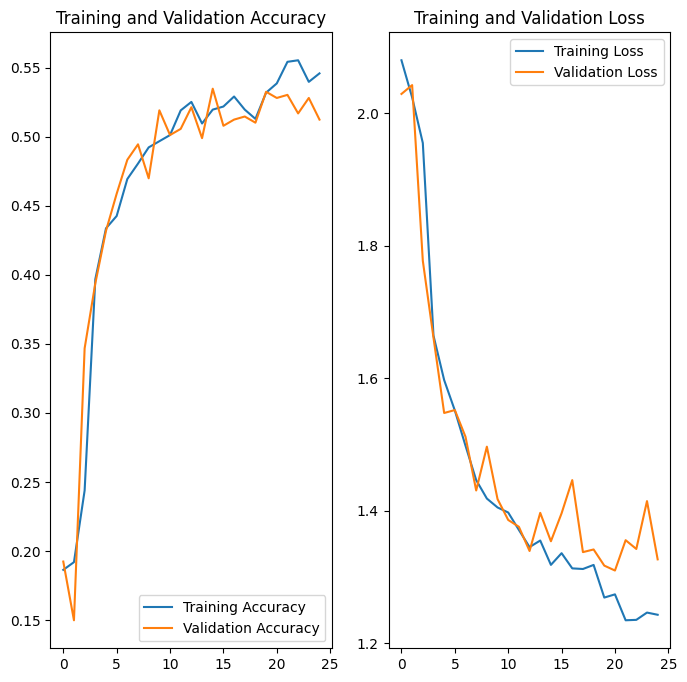

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
* With data augmentation and drop layer, the overfitting of the model is addressed to great extend. Earlier the train and validation accuracy difference was nearly 20%, with latest approach it's reduced to 2-3%.

* The accuracy of the model is compromised heavily and decreased by fair bit from previous vanilla model.

### Analyzing Class Imbalance in Training Dataset

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

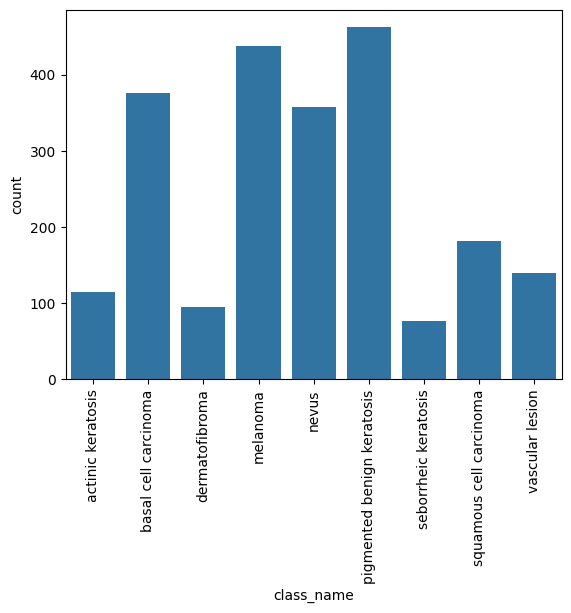

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### Findings
* Data is Heavily imbalanced and hence due to that results and predictions will be biased.



### Balancing Class Using Augmentator

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
import os

path_to_training_dataset = "/content/kaggle_data/isic-classic/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)

    if os.path.exists(class_path):
        p = Augmentor.Pipeline(class_path, output_directory='/content/output_data/'+i+'/output/')
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(1000)
    else:
        print(f"Directory not found: {class_path}")

Initialised with 114 image(s) found.
Output directory set to /content/output_data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DC94A4DA790>: 100%|██████████| 1000/1000 [00:36<00:00, 27.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/output_data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DC8D5472010>: 100%|██████████| 1000/1000 [00:27<00:00, 35.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/output_data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DCA0BDB45D0>: 100%|██████████| 1000/1000 [00:28<00:00, 35.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/output_data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DC8D533E890>: 100%|██████████| 1000/1000 [02:22<00:00,  7.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/output_data/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DC8D54F6490>: 100%|██████████| 1000/1000 [02:17<00:00,  7.26 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/output_data/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DC8D530A390>: 100%|██████████| 1000/1000 [00:27<00:00, 36.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/output_data/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DC8D5205D10>: 100%|██████████| 1000/1000 [01:07<00:00, 14.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/output_data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DC930169210>: 100%|██████████| 1000/1000 [00:26<00:00, 37.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/output_data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DC948C61D90>: 100%|██████████| 1000/1000 [00:28<00:00, 35.33 Samples/s]


In [ ]:
output_dir = pathlib.Path('/content/output_data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

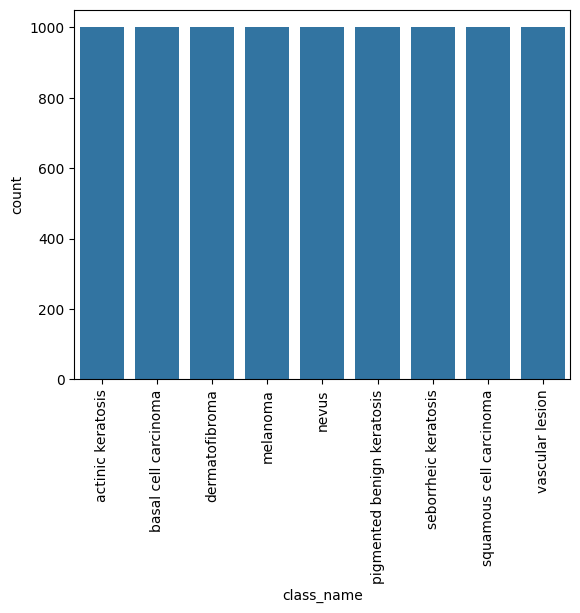

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

### Findings
* A more stable class balance

## Final Model

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
num_classes = 9
model = Sequential([layers.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.1140 - loss: 2.2638 - val_accuracy: 0.1056 - val_loss: 2.1977
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.1115 - loss: 2.1943 - val_accuracy: 0.1056 - val_loss: 2.1977
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.1023 - loss: 2.1977 - val_accuracy: 0.1056 - val_loss: 2.1978
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1043 - loss: 2.1945 - val_accuracy: 0.1217 - val_loss: 2.1976
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.1021 - loss: 2.1976 - val_accuracy: 0.1039 - val_loss: 2.1978
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.1143 - loss: 2.1964 - val_accuracy: 0.1067 - val_loss: 2.1965
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.1561 - loss: 2.1127 - val_accuracy: 0.3544 - val_loss: 1.6743
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.3714 - loss: 1.5738 - 

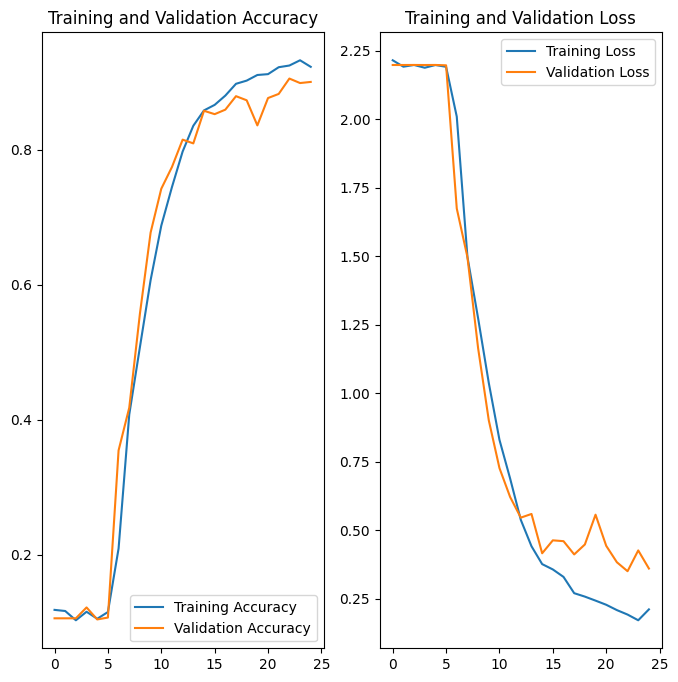

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
* After rebalance/resampling of the data (that gave equal proportion of data) we have raised the accuracy of the model to over 90%.
* Overfitting is mitigated, difference between training and validation is around 4-5%
* This is the best module.

In [ ]:
model.save('model.h5')